# Data Cleaning
This notebook includes analysis with regards to the data cleaning step that is taken for the earthquake damage dataset.

In [20]:
# enables referencing modules in repository
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from scipy.stats import chi2_contingency

from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize
from tabulate import tabulate
from scipy import stats

In [21]:
# Loading the data
train_df = pd.read_csv('../data/raw/train_values.csv')

## Determining the type of features

[to-do] Erklärung schreiben zu warum wo welches Feature zugeordnet wird. Die Zuordnung unten ist erstmal vorläufig von Thomas übernommen, es kann also sein das sich noch Änderungen ergeben nach der Analyse

In [22]:
categorical_columns = [
        'building_id',
        'geo_level_1_id',
        'geo_level_2_id',
        'geo_level_3_id',
        'land_surface_condition',
        'foundation_type',
        'roof_type',
        'ground_floor_type',
        'other_floor_type',
        'position',
        'plan_configuration',
        'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_stone',
        'has_superstructure_stone_flag',
        'has_superstructure_cement_mortar_stone',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_cement_mortar_brick',
        'has_superstructure_timber',
        'has_superstructure_bamboo',
        'has_superstructure_rc_non_engineered',
        'has_superstructure_rc_engineered',
        'has_superstructure_other',
        'legal_ownership_status',
        'has_secondary_use',
        'has_secondary_use_agriculture',
        'has_secondary_use_hotel',
        'has_secondary_use_rental',
        'has_secondary_use_institution',
        'has_secondary_use_school',
        'has_secondary_use_industry',
        'has_secondary_use_health_post',
        'has_secondary_use_gov_office',
        'has_secondary_use_use_police',
        'has_secondary_use_other'
    ]

numerical_columns = [
    'count_floors_pre_eq',
    'age',
    'area_percentage',
    'height_percentage',
    'count_families'
    ]

## Finding Outliers in the dataset
---

1. `building_id` seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` these features seem to describe the location the building is located in.
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` likely class of building structure
12. `has_superstructure..` likely a one hot encoded feature that represents the type of used superstructure
13. `legal_ownership_status` likely who the building belongs to
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use..` seems to describe whether the building had an additional purpose than living in it


### Strategies for finding Outliers
The following strategies are used for outlier analysis in this notebook.
#### 1. interquartile range (IQR)
IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). Using the IQR, the outlier data points are the ones falling below Q1–1.5 IQR or above Q3 + 1.5 IQR. 

Where Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset, and IQR represents the interquartile range calculated by Q3 minus Q1 (Q3–Q1). 

#### 2. Boxplot
With the help of a boxplot it is possible to visually inspect the data for the presence of outliers. If there are outliers in the data, they will be represented as points outside the whiskers of the box plot.

### Strategies for handeling outliers
The following strategies could be used for handling the outliers that have been found.
#### 1. Dropping the data row including the outlier
With this method all data rows are dropped that include values that have been marked as outliers.
#### 2. Capping the outlier
With this method a min and max value is set. Every value that is above or below the cap gets set to the capped value.

### Analysing the numerical features
Using IQR we calculate whether the numerical features classified as such above contain outliers. The function below reports a dataframe that contains the amount of outliers that have been calculated for that particular feature and the min and max value of the feature.

In [4]:
# Using IQR zu calculate which numerical features have outliers
outliers = {}
for feature in train_df[numerical_columns]:
    outliers[feature] = build_features.find_outliers_IQR(train_df[feature])

outlier_df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minValue', 'maxValue', 'mean', 'median', 'mode'])
for feature in outliers:
    amount = str(len(outliers[feature]))
    min = str(outliers[feature].min())
    max = str(outliers[feature].max())
    mean = stat.mean(train_df[feature])
    median = stat.median(train_df[feature])
    mode = stat.mode(train_df[feature])
    outlier_df.loc[len(outlier_df)] = [feature, amount, min, max, mean, median, mode]

print(tabulate(outlier_df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+------------+------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minValue |   maxValue |      mean |   median |   mode |
|----+---------------------+-----------------+------------+------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |          103978 |          1 |          9 |  2.12972  |        2 |      2 |
|  1 | age                 |           12499 |         65 |        995 | 26.535    |       15 |     10 |
|  2 | area_percentage     |           13557 |         16 |        100 |  8.01805  |        7 |      6 |
|  3 | height_percentage   |            7843 |         10 |         32 |  5.43437  |        5 |      5 |
|  4 | count_families      |           34486 |          0 |          9 |  0.983949 |        1 |      1 |
+----+---------------------+-----------------+------------+------------+-----------+----------+--------+


In [17]:
outliers = {}
for feature in train_df[numerical_columns]:
    outliers[feature] = np.abs(stats.zscore(train_df[feature]))
    
outlier_df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minValue', 'maxValue', 'mean', 'median', 'mode'])
for feature in outliers:
    outliers_idx = (outliers[feature] >= 3) | (outliers[feature] <= -3)
    outlier_amount = outliers_idx.sum()
    outlier_min = train_df[feature][outliers_idx].min()
    outlier_max = train_df[feature][outliers_idx].max()
    outlier_mean = train_df[feature][~outliers_idx].mean()
    outlier_median = train_df[feature][~outliers_idx].median()
    outlier_mode = train_df[feature][~outliers_idx].mode()[0]
    outlier_df.loc[len(outlier_df)]  = {'featureName': feature, 'outlierAmount': outlier_amount, 'minValue': outlier_min, 'maxValue': outlier_max, 'mean': outlier_mean, 'median': outlier_median, 'mode': outlier_mode}

print(tabulate(outlier_df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+------------+------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minValue |   maxValue |      mean |   median |   mode |
|----+---------------------+-----------------+------------+------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |            2496 |          5 |          9 |  2.10083  |        2 |      2 |
|  1 | age                 |            1390 |        995 |        995 | 21.3417   |       15 |     10 |
|  2 | area_percentage     |            3845 |         22 |        100 |  7.70481  |        7 |      6 |
|  3 | height_percentage   |            2434 |         12 |         32 |  5.35243  |        5 |      5 |
|  4 | count_families      |            2330 |          3 |          9 |  0.962954 |        1 |      1 |
+----+---------------------+-----------------+------------+------------+-----------+----------+--------+


## 1. Analysis for `building_id`
This feature describes the unique id for each building. For this reason it provides no further information for the predicion model.

## 2. Analysis for `geo_level_1_id`

As the distribution below is showing

In [50]:
train_df.geo_level_1_id.describe()

count    260601.000000
mean         13.900353
std           8.033617
min           0.000000
25%           7.000000
50%          12.000000
75%          21.000000
max          30.000000
Name: geo_level_1_id, dtype: float64

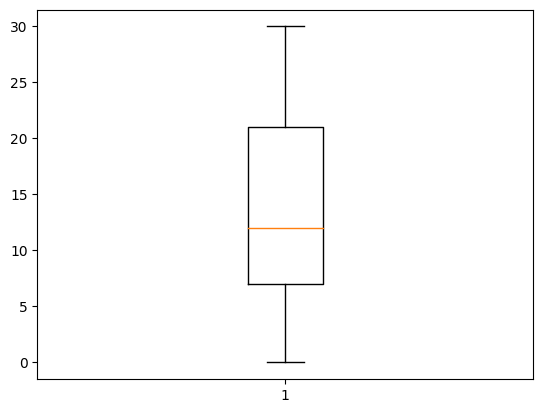

In [51]:
# create a box plot
plt.boxplot(train_df['geo_level_1_id'])
plt.show()

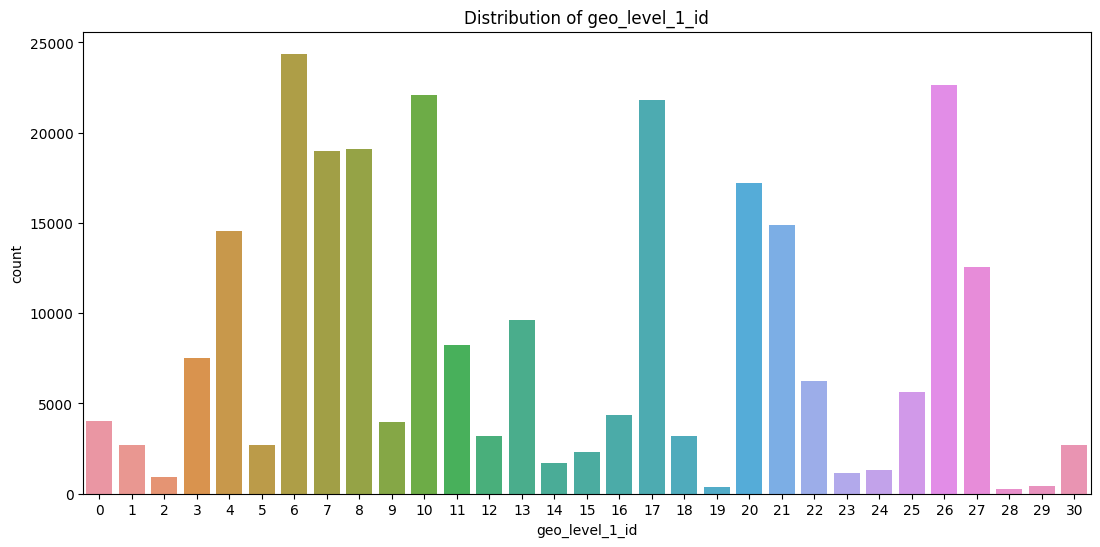

In [52]:
plt.figure(figsize=(13,6))
sns.countplot(data=train_df, x='geo_level_1_id')
plt.title("Distribution of geo_level_1_id")
plt.show()

In [53]:
#outliers = build_features.find_outliers_IQR(train_df.select_dtypes(include='number'))
outliers = build_features.find_outliers_IQR(train_df['geo_level_1_id'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))


number of outliers: 0
max outlier value: nan
min outlier value: nan


-------------

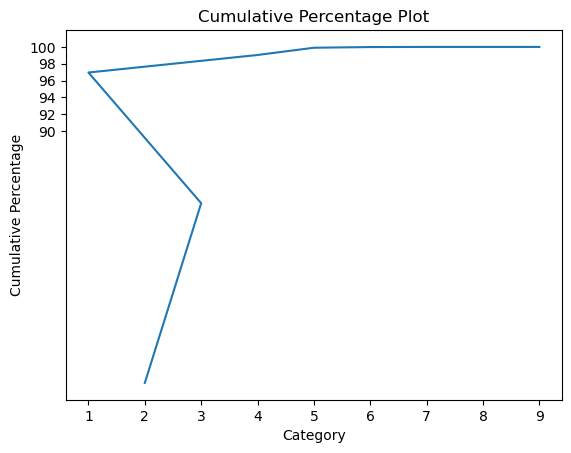

In [54]:
cumulative_sum = train_df['count_floors_pre_eq'].value_counts().sort_values(ascending=False).cumsum()

cumulative_percentage = 100 * cumulative_sum / cumulative_sum.max()

# plot the cumulative percentage
plt.plot(cumulative_percentage.index, cumulative_percentage)

# set the plot title and axis labels
plt.title('Cumulative Percentage Plot')
plt.xlabel('Category')
plt.ylabel('Cumulative Percentage')
yticks = np.arange(90, 102,2)
ylabels = [f"{y:.0f}%" for y in yticks]
plt.yticks(yticks)
# show the plot
plt.show()

Check all categorical features of train_df, if a value of a feature goes above the set threshold, the feature is considered imbalanced.

In [23]:
# threshold between 0 and 1
threshold = 0.9
imbalancedFeatures = build_features.check_dataframe_for_imbalanced_features(train_df, threshold)
print(imbalancedFeatures)

[]


In [24]:
def create_threshold_hist(df_series, threshold):
    print(f'Threshold: Rows of plan_configuration x {threshold} = {int(df_series.count() * threshold)}')
    print(df_series.value_counts())
    
    thresholdLine = threshold * df_series.count()
    df_series.hist()
    plt.axhline(y=thresholdLine, color='r', linestyle='-')
    plt.title(df_series.name)
    plt.ylabel('Count')
    plt.savefig(f'../reports/figures/histogramm_{df_series.name}.svg', format='svg')
    plt.show()

Threshold: Rows of plan_configuration x 0.9 = 234540
d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64


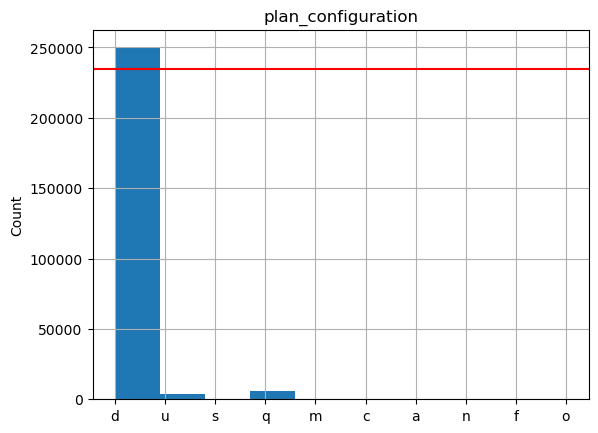

In [25]:
threshold = 0.9
col = 'plan_configuration'
create_threshold_hist(train_df[col], threshold)

The value 'd' of feature plan_configuration occurs more often than the given threshold allows, so this feature will later be dropped.

Threshold: Rows of plan_configuration x 0.9 = 234540
r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64


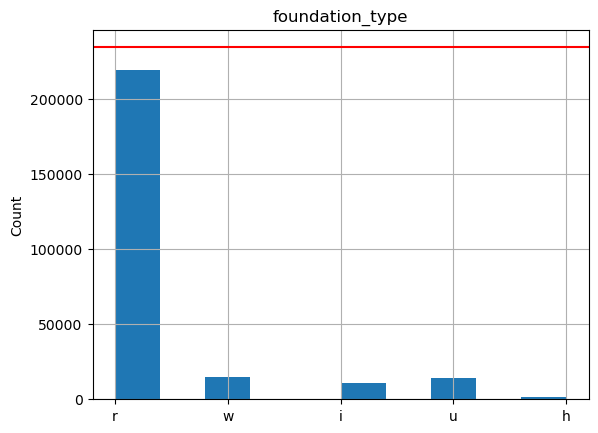

In [26]:
threshold = 0.9
col = 'foundation_type'
create_threshold_hist(train_df[col], threshold)

The values of feature plan_configuration are all below than the given threshold, so the feature won't be dropped.